In [3]:
# project root へ移動
%cd ..
%pwd

/Users/heste/workspace/soccernet/tracklab


'/Users/heste/workspace/soccernet/tracklab'

In [29]:
import os
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd

# Dataframe 表示時の truncation を防ぐ
pd.set_option('display.max_colwidth', 200)

In [5]:
from dataclasses import dataclass
from glob import glob

@dataclass
class GSR_States:
    gamestate_zip_file: Path
    gamestate_summary_file: Path
    gamestate_file: Path
    gamestate_images_file: Path
    gamestate_df: pd.DataFrame
    image_df: pd.DataFrame
    
    @classmethod
    def initialize(cls, gamestate_zip_file: Path):
        gamestate_zip_file = gamestate_zip_file
        
        parent_dir = gamestate_zip_file.parent
        
        if not (parent_dir / "summary.json").exists():
            zipfile.ZipFile(gamestate_zip_file).extractall(parent_dir)
        
        # 見つける the summary.json file
        gamestate_summary_file = parent_dir / "summary.json"
        
        # 見つける the / {data_id}.pkl file
        for path in glob(str(parent_dir / "*.pkl")):
            if "_image.pkl" in path:
                gamestate_images_file = Path(path)
            else:
                # {data_id} はどこにも記載されていないので、とりあえず_image.pklではないものを gamestate_file とする
                gamestate_file = Path(path)
        
        gamestate_df = pd.read_pickle(gamestate_file)
        image_df = pd.read_pickle(gamestate_images_file)
        
        return GSR_States(
            gamestate_zip_file=gamestate_zip_file,
            gamestate_summary_file=gamestate_summary_file,
            gamestate_file=gamestate_file,
            gamestate_images_file=gamestate_images_file,
            gamestate_df=gamestate_df,
            image_df=image_df
        )


class NotebookArgs:
    gsr_result_path = Path("outputs/sn-gamestate/2024-07-03/12-10-22/states/sn-gamestate-1.pklz")
    soccernet_v2_result_path = Path("outputs/sn-gamestate-1/2024-08-26/18-01-52/states/sn-gamestate-1.pklz")
    soccernet_v2_result_exp003_path = Path("outputs/sn-gamestate-exp003/2024-09-12/22-43-17/states/sn-gamestate-exp003.pklz")

In [6]:
# sn-gamestate test data で実行した結果を読み込む
gsr_states = GSR_States.initialize(NotebookArgs.gsr_result_path)
soccernetv2_states = GSR_States.initialize(NotebookArgs.soccernet_v2_result_path)
exp003_states = GSR_States.initialize(NotebookArgs.soccernet_v2_result_exp003_path)


In [7]:
def bbox_to_3x3_position(bbox_ltwh, image_shape = [720, 1280]) -> str:
    image_height, image_width = image_shape
    left, top, width, height = bbox_ltwh
    
    bbox_center_x = left + width / 2
    bbox_center_y = top + height / 2
    
    assert 0 <= bbox_center_x <= image_width
    assert 0 <= bbox_center_y <= image_height
    
    # 3x3 grid に変換
    x = int(3 * bbox_center_x / image_width)
    y = int(3 * bbox_center_y / image_height)
    
    x_str_map = {
        0: "left",
        1: "middle",
        2: "right"
    }
    
    y_str_map = {
        0: "top",
        1: "middle",
        2: "bottom"
    }
    
    return f"{y_str_map[y]}-{x_str_map[x]}"

In [8]:
soccernetv2_states.gamestate_df.columns

Index(['image_id', 'bbox_ltwh', 'bbox_conf', 'video_id', 'category_id',
       'body_masks', 'embeddings', 'role_confidence', 'role_detection',
       'visibility_scores', 'age', 'costs', 'hits', 'matched_with', 'state',
       'time_since_update', 'track_bbox_kf_ltwh', 'track_bbox_pred_kf_ltwh',
       'track_id', 'bbox_pitch', 'jersey_number_confidence',
       'jersey_number_detection', 'jersey_number', 'role', 'team_cluster',
       'team', 'ignored'],
      dtype='object')

In [9]:
# bbox_ltwh, bbox_pitch の比較
gsr_states.gamestate_df[["bbox_ltwh", "bbox_pitch"]].head(1)

,bbox_ltwh,bbox_pitch
0,"[477.2666, 565.18243, 51.357056, 140.48798]","{'x_bottom_left': 30.024707089385405, 'y_bottom_left': 1.8079211847110246, 'x_bottom_right': 30.53447607846876, 'y_bottom_right': 2.192438495599093, 'x_bottom_middle': 30.279568725016258, 'y_bottom_middle': 2.0001625977425355}"


In [10]:
soccernetv2_states.gamestate_df[["bbox_ltwh", "bbox_pitch"]].head(1)

,bbox_ltwh,bbox_pitch
0,"[243.80844, 160.7894, 8.895187, 29.814362]","{'x_bottom_left': -541.6153980820112, 'y_bottom_left': -728.9938905175867, 'x_bottom_right': -536.6539643856011, 'y_bottom_right': -731.9756797471662, 'x_bottom_middle': -539.1397055017429, 'y_bottom_middle': -730.4817655801756}"


In [11]:
soccernetv2_states.image_df.columns

Index(['frame', 'id', 'video_id', 'file_path', 'lines', 'parameters'], dtype='object')

In [12]:
# track_idの数 = 同一オブジェクトとして認識された数
# 完全バラバラなのか、ある程度フレーム間で同一オブジェクトが認識されているのかを確認する指標として使えるのでは？
# 0.09 -> これがどれくらいの割合なのかがわからない
snv2_rate = soccernetv2_states.gamestate_df["track_id"].nunique() / len(soccernetv2_states.gamestate_df)

# gsrでもやる
gsr_rate = gsr_states.gamestate_df["track_id"].nunique() / len(gsr_states.gamestate_df)

print(f"SNv2: {snv2_rate:.3f}, GSR: {gsr_rate:.3f}") 
# SNv2: 0.091, GSR: 0.011 
# 仮説と真逆の結果になった
# うーん、これはどういうことなのか

SNv2: 0.091, GSR: 0.011


In [13]:
soccernetv2_states.gamestate_df[["image_id", "bbox_ltwh", "jersey_number_detection", "role", "team"]].head(20)

,image_id,bbox_ltwh,jersey_number_detection,role,team
0,1005_1000001,"[243.80844, 160.7894, 8.895187, 29.814362]",NaN,player,right
1,1005_1000001,"[7.6811314, 144.12244, 7.3517103, 29.524902]",NaN,player,left
2,1005_1000001,"[129.51042, 106.73213, 6.3617706, 21.203796]",NaN,ball,nan
3,1005_1000001,"[301.83694, 111.528336, 6.7047424, 24.376312]",NaN,player,left
4,1005_1000001,"[140.21762, 88.23965, 6.615967, 15.968224]",NaN,ball,nan
5,1005_1000001,"[368.69278, 88.37085, 9.361664, 18.446312]",NaN,player,left
6,1005_1000001,"[200.84027, 109.04617, 9.060608, 19.065567]",NaN,player,left
7,1005_1000001,"[112.754944, 95.72863, 7.3474884, 16.682106]",NaN,player,left
8,1005_1000001,"[178.49332, 105.726234, 9.825851, 16.806038]",NaN,player,left
9,1005_1000001,"[223.4625, 100.75325, 6.9635925, 18.82914]",NaN,player,left


In [14]:
soccernetv2_states.gamestate_df["jersey_number_detection"].describe()

count     404
unique     44
top        00
freq       98
Name: jersey_number_detection, dtype: object

In [15]:
soccernetv2_states.gamestate_df["jersey_number_confidence"].describe()

count    38282.000000
mean         0.008563
std          0.085263
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: jersey_number_confidence, dtype: float64

In [16]:
gsr_states.gamestate_df.loc[
    gsr_states.gamestate_df["jersey_number_detection"].notnull(), 
    ["image_id", "jersey_number_detection", "role", "team"]].head(20)

,image_id,jersey_number_detection,role,team
48,3116000004,33,player,right
76,3116000006,93,player,left
80,3116000006,33,player,right
91,3116000007,19,player,left
107,3116000008,13,player,left
112,3116000008,33,player,right
123,3116000009,33,player,left
128,3116000009,33,player,right
139,3116000010,93,player,left
144,3116000010,3,player,right


In [87]:
exp003_states.gamestate_df.loc[exp003_states.gamestate_df["jersey_number_detection"].notnull() & (exp003_states.gamestate_df["role_detection"] == "player"), ["image_id", "jersey_number_detection", "role", "team"]]

,image_id,jersey_number_detection,role,team
415,1005_1000042,00,player,right
596,1005_1000059,2,player,right
697,1005_1000071,00,player,right
698,1005_1000071,11,player,right
702,1005_1000072,11,player,right
...,...,...,...,...
50577,1005_1005391,10,player,left
50596,1005_1005392,18,player,left
50613,1005_1005393,42,player,left
50615,1005_1005393,18,player,left


In [18]:
soccernetv2_states.image_df.columns

Index(['frame', 'id', 'video_id', 'file_path', 'lines', 'parameters'], dtype='object')

In [32]:
soccernetv2_states.image_df[["frame", "lines", "parameters"]].head()

,frame,lines,parameters
id,,,
1005_1000001,0,"{'Circle central': [{'x': 0.47912087912087914, 'y': 0.49609375}, {'x': 0.5758241758241758, 'y': 0.4921875}, {'x': 0.6945054945054945, 'y': 0.52734375}, {'x': 0.6681318681318681, 'y': 0.640625}, {'...","{'pan_degrees': 2.6825742721557617, 'tilt_degrees': 67.84307861328125, 'roll_degrees': -0.8659389615058899, 'position_meters': [0.06817737966775894, 78.21742248535156, -24.714509963989258], 'x_foc..."
1005_1000002,1,"{'Circle central': [{'x': 0.47692307692307695, 'y': 0.65625}, {'x': 0.578021978021978, 'y': 0.6640625}, {'x': 0.6945054945054945, 'y': 0.625}, {'x': 0.6615384615384615, 'y': 0.51171875}, {'x': 0.5...","{'pan_degrees': 3.532975196838379, 'tilt_degrees': 67.34796142578125, 'roll_degrees': -1.3986132144927979, 'position_meters': [-0.01665681041777134, 81.40090942382812, -23.908008575439453], 'x_foc..."
1005_1000003,2,"{'Circle central': [{'x': 0.4835164835164835, 'y': 0.46875}, {'x': 0.5846153846153846, 'y': 0.4921875}, {'x': 0.7186813186813187, 'y': 0.5390625}, {'x': 0.6505494505494506, 'y': 0.6484375}, {'x': ...","{'pan_degrees': 2.5546207427978516, 'tilt_degrees': 67.7827835083008, 'roll_degrees': -1.1426992416381834, 'position_meters': [-0.2882041931152344, 80.49137878417969, -24.0777587890625], 'x_focal_..."
1005_1000004,3,"{'Circle central': [{'x': 0.7252747252747253, 'y': 0.6484375}, {'x': 0.5956043956043956, 'y': 0.6796875}, {'x': 0.4747252747252747, 'y': 0.68359375}, {'x': 0.35384615384615387, 'y': 0.66015625}, {...","{'pan_degrees': -2.5973498821258554, 'tilt_degrees': 68.51156616210938, 'roll_degrees': -0.047029443085193634, 'position_meters': [0.3538846969604492, 78.7445297241211, -24.351716995239258], 'x_fo..."
1005_1000005,4,"{'Circle central': [{'x': 0.5208791208791209, 'y': 0.5}, {'x': 0.3868131868131868, 'y': 0.515625}, {'x': 0.2703296703296703, 'y': 0.60546875}, {'x': 0.3978021978021978, 'y': 0.6875}, {'x': 0.54285...","{'pan_degrees': -4.921325206756593, 'tilt_degrees': 68.29093170166016, 'roll_degrees': 0.09661880135536191, 'position_meters': [-0.9640040993690491, 80.0218276977539, -23.958696365356445], 'x_foca..."


In [34]:
gsr_states.gamestate_df.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344, 9345],
      dtype='int64', length=9346)

In [22]:
# SoccerNet-v2 exp001 背番号の認識がうまくいっているレコードを表示
soccernetv2_states.gamestate_df.loc[
    soccernetv2_states.gamestate_df["jersey_number_confidence"] > 0.5, ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
429,1005_1000058,10,0.953834,player,right
504,1005_1000071,00,0.997413,player,right
510,1005_1000072,11,0.744189,player,right
528,1005_1000079,00,0.996611,player,right
641,1005_1000100,28,0.988316,player,right
659,1005_1000101,28,1.000000,player,right
680,1005_1000104,2,0.964653,player,right
689,1005_1000105,11,0.990380,player,right
734,1005_1000109,9,0.542806,player,right
929,1005_1000131,09,0.513052,player,right


In [25]:
# GSR test 背番号の認識がうまくいっているレコードを表示

gsr_states.gamestate_df.loc[
    gsr_states.gamestate_df["jersey_number_confidence"] > 0.5, 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
48,3116000004,33,0.999999,player,right
76,3116000006,93,0.894604,player,left
80,3116000006,33,0.999996,player,right
91,3116000007,19,0.754866,player,left
107,3116000008,13,0.831190,player,left
112,3116000008,33,0.999995,player,right
123,3116000009,33,0.995262,player,left
128,3116000009,33,1.000000,player,right
139,3116000010,93,0.998286,player,left
144,3116000010,3,0.820008,player,right


In [14]:
# GSR test 背番号の認識がうまくいっているレコードを表示

exp003_states.gamestate_df.loc[
    exp003_states.gamestate_df["jersey_number_confidence"] > 0.5, 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
415,1005_1000042,00,1.000000,player,right
596,1005_1000059,2,0.901147,player,right
615,1005_1000064,5,0.962113,player,right
697,1005_1000071,00,1.000000,player,right
698,1005_1000071,11,0.845412,player,right
702,1005_1000072,11,0.718771,player,right
707,1005_1000072,00,1.000000,player,right
710,1005_1000073,11,0.865649,player,right
714,1005_1000073,00,1.000000,player,right
717,1005_1000074,00,1.000000,player,right


In [24]:
# nunber: 28	confidence: 1.0 の画像についての情報を表示
soccernetv2_states.gamestate_df.loc[
    soccernetv2_states.gamestate_df["image_id"] == "1005_1000101", 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
]

,image_id,jersey_number_detection,jersey_number_confidence,role,team
650,1005_1000101,NaN,0.0,player,right
651,1005_1000101,NaN,0.0,player,right
652,1005_1000101,NaN,0.0,player,right
653,1005_1000101,NaN,0.0,player,right
654,1005_1000101,NaN,0.0,player,right
655,1005_1000101,NaN,0.0,player,right
656,1005_1000101,NaN,0.0,player,right
657,1005_1000101,NaN,0.0,player,right
658,1005_1000101,NaN,0.0,player,right
659,1005_1000101,28,1.0,player,right


In [17]:
# nunber: 28	confidence: 1.0 の画像についての情報を表示
exp003_states.gamestate_df.loc[
    exp003_states.gamestate_df["image_id"] == "1005_1000101", 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team", "bbox_ltwh"]
]

,image_id,jersey_number_detection,jersey_number_confidence,role,team,bbox_ltwh
907,1005_1000101,NaN,0.0,player,right,"[153.0094, 135.56726, 235.3341, 578.15063]"
908,1005_1000101,NaN,0.0,player,right,"[712.9668, 97.75928, 269.573, 569.2031]"
909,1005_1000101,28,1.0,player,right,"[272.69604, 126.64844, 310.56128, 582.92615]"
910,1005_1000101,NaN,0.0,player,right,"[521.3635, 49.18927, 190.74744, 467.8197]"
911,1005_1000101,NaN,0.0,player,right,"[980.4829, 65.16107, 208.88647, 475.29663]"
912,1005_1000101,NaN,0.0,player,right,"[0.24652863, 371.494, 101.78488, 343.13162]"
913,1005_1000101,NaN,0.0,player,right,"[61.342472, 383.95923, 125.392944, 115.45123]"
914,1005_1000101,NaN,0.0,player,right,"[0.05418396, 238.16867, 167.01042, 221.81335]"
915,1005_1000101,NaN,0.0,player,right,"[801.52344, 482.85834, 297.58716, 234.11304]"
916,1005_1000101,NaN,0.0,player,right,"[1157.7975, 140.54773, 121.202515, 411.89026]"


In [101]:
# 概要: 背番号の認識割合
# 目的: 画像サイズの違いが、背番号認識の精度にどのような影響を与えるかを調査する
# 結果: exp003(720p)だと、GSR(1080p)に近い認識割合を出している

# 手順
def get_jersey_number_rate(states: GSR_States):
    detected_size = (
        states
        .gamestate_df
        .loc[
            states.gamestate_df["jersey_number_detection"].notnull()
            & states.gamestate_df["role_detection"].isin(["player", "goolkeeper"])
        ]
        .size
    )
    should_detect_size =  (
        states
        .gamestate_df
        .loc[
            states.gamestate_df["role_detection"].isin(["player", "goolkeeper"])
        ]
        .size
    )
    return detected_size / should_detect_size

# snv2 exp001
snv2_rate = get_jersey_number_rate(soccernetv2_states)

# gsr
gsr_rate = get_jersey_number_rate(gsr_states)

# exp003
exp003_rate = get_jersey_number_rate(exp003_states)

print("背番号の認識割合(Not Null)")
print(f"SNv2: {snv2_rate:.3f}, GSR: {gsr_rate:.3f}, exp003: {exp003_rate:.3f}")

背番号の認識割合(Not Null)
SNv2: 0.013, GSR: 0.041, exp003: 0.039


<Axes: >

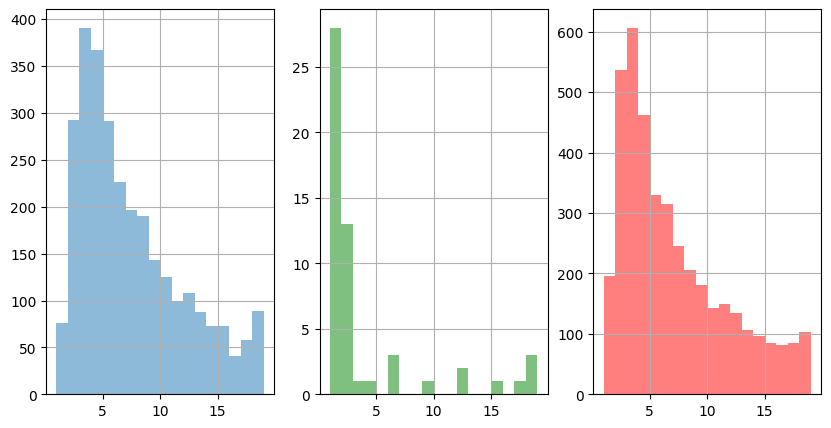

In [62]:
# 概要: 各objectが持続するフレーム数の分布を調べる
# 目的: 2fpsなv2なデータで、どれくらいうまく trackingいってるのかを調べる
# 結果: 分布の歪度と裾の広さはあまり変わらなかった。そもそも gsr データで全然うまくいってない..?

# 手順は以下の通り
# soccernetv2_statesとgsr_statesのヒストグラムを比較する
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# track_idでグルーピングして、サイズの分布をみる
soccernetv2_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 20), ax=ax[0], alpha=0.5, label="soccernetv2")

# 山が5付近, 5 (frame) /  2 (frame/sec) = 2.5 sec ごとにオブジェクトが更新されている（画面が切り替わる？）
# 2.5secごとにシーン切り替えはちょっと早くない？

# フレームレートの分析
# track_idでグルーピングして、サイズの分布をみる
gsr_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 20), ax=ax[1], alpha=0.5, label="gsr", color="green")

# soccernet-v2 exp003
exp003_states.gamestate_df.groupby("track_id").size().hist(bins=range(1, 20), ax=ax[2], alpha=0.5, label="exp003", color="red")


In [64]:
# 概要: track_id の数をシンプルに比較する
# 目的: tracking の精度を比較する(fpsの違いを考慮する必要がある)
# 結果: 画像一枚あたりのtrackingオブジェクトのユニーク数が、GSRと比べてSNV2は5倍程度多い
# これは、fpsの違いが影響しているのかもしれない (fpsを上げるべきかも...)

# 手順
# 1. track_id の数を比較する
def count_track_id(states: GSR_States):
    return states.gamestate_df["track_id"].nunique()

def count_track_id_by_image_num(states: GSR_States):
    return count_track_id(states) / states.gamestate_df["image_id"].nunique()

gsr_track_id = count_track_id(gsr_states)
snv2_track_id = count_track_id(soccernetv2_states)
exp003_track_id = count_track_id(exp003_states)

print("trackingオブジェクトのユニーク数")
print(f"SNv2: {snv2_track_id}, GSR: {gsr_track_id}, exp003: {exp003_track_id}")
print("")
print("画像一枚あたりのtrackingオブジェクトのユニーク数")
print(f"SNv2: {count_track_id_by_image_num(soccernetv2_states):.3f}, GSR: {count_track_id_by_image_num(gsr_states):.3f}, exp003: {count_track_id_by_image_num(exp003_states):.3f}")

trackingオブジェクトのユニーク数
SNv2: 3478, GSR: 106, exp003: 4799

画像一枚あたりのtrackingオブジェクトのユニーク数
SNv2: 0.659, GSR: 0.141, exp003: 0.893


<Axes: >

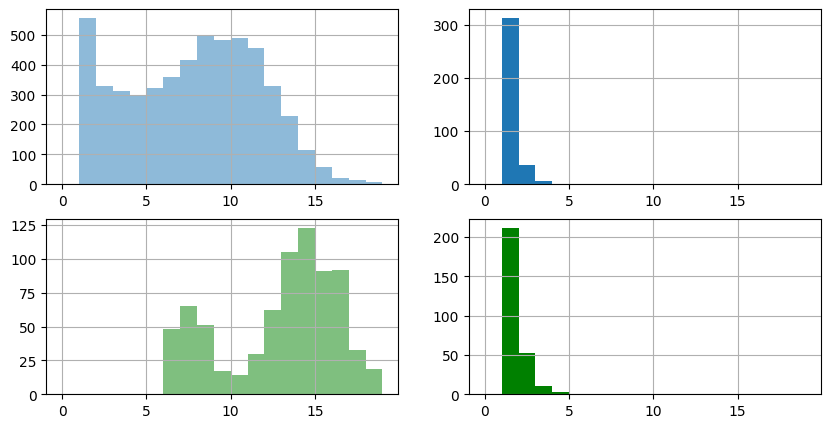

In [48]:
# 概要:画像一枚につき、(1)何このオブジェクトがあるか (2)何個の背番号認識成功オブジェクトがあるか ヒストグラムで確認
# 目的:画像一枚がどれだけ使えそうな情報を持っているかを知りたい
# 結果：どちらも変わらない->v2でも十分情報取れそう?


fig, ax = plt.subplots(2, 2, figsize=(10, 5))
# soccernetv2
## (1)何このオブジェクトがあるか
(
    soccernetv2_states
    .gamestate_df
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[0,0], alpha=0.5, label="soccernetv2-obj")
)
# (2)何個の背番号認識成功オブジェクトがあるか
(
    soccernetv2_states
    .gamestate_df
    .loc[soccernetv2_states.gamestate_df["jersey_number_detection"].notnull(), ["jersey_number_detection", "image_id"]]
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[0,1], alpha=1, label="soccernetv2-jersey")
)

# gsr
## (1)何このオブジェクトがあるか
(
    gsr_states
    .gamestate_df
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[1,0], alpha=0.5, label="gsr-obj", color="green")
)
# (2)何個の背番号認識成功オブジェクトがあるか
(
    gsr_states
    .gamestate_df
    .loc[gsr_states.gamestate_df["jersey_number_detection"].notnull(), ["jersey_number_detection", "image_id"]]
    .groupby(["image_id"])
    .size()
    .hist(bins=range(0, 20), ax=ax[1,1], alpha=1, label="gsr-jersey", color="green")
)


In [58]:
# 概要: 画像一枚につき少なくとも背番号認識成功オブジェクトが1つある割合
# 目的: 画像一枚がどれだけ使えそうな情報を持っているかを知りたい
# 結果: gsrと比べてかなり低い。つまり、soccernetでは情情報量ゼロの画像が多い

def get_rate_of_image_with_jersey_number(states: GSR_States):
    result = (
        states
            .gamestate_df.loc[states.gamestate_df["jersey_number_detection"].notnull(), ["image_id"]]
            .nunique() 
        / states
            .gamestate_df["image_id"]
            .nunique()
    )
    return result["image_id"]

# soccernetv2
v2_exp001_rate_result = get_rate_of_image_with_jersey_number(soccernetv2_states)
# gsr
gsr_rate_result = get_rate_of_image_with_jersey_number(gsr_states)

print(f"SNv2: {v2_exp001_rate_result:.3f}, GSR: {gsr_rate_result:.3f}")

SNv2: 0.067, GSR: 0.371
